# Robust spectral line tracing
In this notebook, we will attempt to trace time-varying frequency components in a very noisy signal.

We will make use of two main concepts:
- A low-rank filter
- Linear Time-Varying models (LTV models)

The low-rank filter was explored in a [previous notebook](https://github.com/baggepinnen/julia_examples/blob/master/identification_robust.ipynb) so we assume for now that this needs no introduction.
The LTV model however might need a few words before we begin.

A linear time-invariant system is often written on the form
$$y_{t+1} = \sum_{k=0:n-1} a_ky_{t-k}$$
where $y$ is some interesting signal. Oftentimes we can not observe $y$ directly, rather we observe a noisy version
$y_n = y + e$
where $e$ is the noise. If $e$ is Gaussian all is fine and dandy and we can employ a lot of common methods to identify the coefficients $a$ in the linear model. When $e$ is something more nasty, we're in trouble. In this notebook, $e$ will be very impulsive $\alpha$-sub Gaussian noise with autocorrelation, making most common estimation techniques cry. This kind of noise was also introduced in the [previous notebook](https://github.com/baggepinnen/julia_examples/blob/master/identification_robust.ipynb).

An LTI system can model a signal with a fixed number of frequency components. Two $a$-coefficients are needed per component (one component has two parameters, amplitude/phase). If the frequency components change with time, so must the $a$-coefficients do. A linear model with time-varying coefficients is called an LTV model. We will use identification methods from [this thesis](https://arxiv.org/abs/1906.02003) for estimation of the LTV models using a Kalman smoother and the package [LTVModels.jl](https://github.com/baggepinnen/LTVModels.jl).

We start by generating a signal containing a linear chirp and a funny sinusoidal chirp.

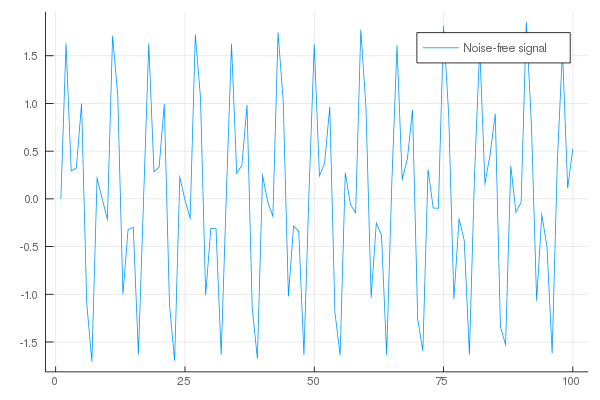

In [7]:
using Random, LinearAlgebra, Statistics
using TotalLeastSquares, DSP, LTVModels, ControlSystems, LPVSpectral, AlphaStableDistributions, Plots
gr()
T        = 2^14                                 # Number of samples
fs       = 16_000                               # Sample frequency
t        = range(0,step=1/fs, length=T)         # time vector
chirp_f1 = LinRange(2000, 2500, T)              # frequency of chirp
chirp_f2 = 5000 .+ 200sin.(2pi/T .* (1:T))
y        = sin.(2pi .* chirp_f1 .* t )          # clean signal
y      .+= sin.(2pi .* chirp_f2 .* t )       
plot(y[1:100], lab="Noise-free signal")

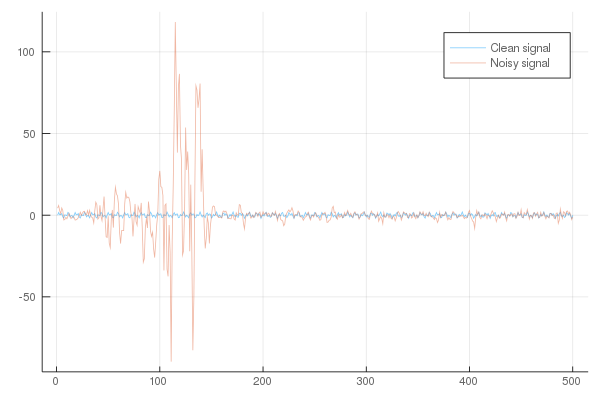

In [8]:
Random.seed!(0)
e  = rand(AlphaSubGaussian(n=T))
yn = y + e
plot([y yn][1:500,:], lab=["Clean signal" "Noisy signal"], alpha=0.5)

It should be apparent from the figure above that the noise is rather dramatic and nasty.

Next, we select some parameter for the Kalman smoother that estimates the LTV model. 

In [9]:
eye(n) = Matrix{Float64}(I(n))
n  = 6          # Order of the LTV model. 6 poles means we can estimate 3 frequencies.
R1 = eye(n)
R2 = [1e5]      # This parameter contrrols the amount of smoothing
P0 = 1e4R1
D  = 2;         # Can be set to 2 for added filter momentum

Next, we apply the low-rank filter over overlapping windows in order to robustly filter out the impulsive noise. Over a short window, the signal is approximately time invariant and thus of rank 4 (two for each frequency).

In [10]:
@time yf = mapwindows(Windows2(yn,1:length(yn),length(yn)÷20)) do (yn,t)
    yf = lowrankfilter(yn,400,lag=8)
end
@time model = KalmanAR(yf,R1,R2,P0,extend=true, printfit=false, D=D);

  1.018687 seconds (146.13 k allocations: 269.292 MiB, 2.13% gc time)
  0.659918 seconds (966.78 k allocations: 397.170 MiB, 46.07% gc time)


We next define a function to calculate the roots of the polynomials in the estimated LTV model and convert these roots to a spectrogram. We then plot the root spectrogram together with Welch's spectrogram. For comparison, we plot the spectrogram of the noise free signal to the left, and the corrupted signal and estimation to the right.

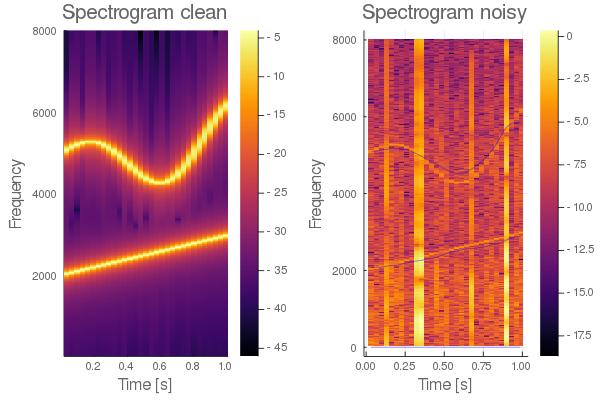

In [11]:
function rootspectrogram(model, fs)
    roots = map(1:length(model)) do i
        sys = tf(1,[1;-reverse(model.θ[:,i])],1)        # create a transfer function from the coefficients
        p = sort(pole(sys), by=imag, rev=true)[1:end÷2] # calculate poles and throw away those with negative imag
        p = fs/(2pi) .* angle.(p)       # The frequency of a pole is approx its angle times the sample rate
        sort(replace(p, fs÷2=>0))
    end
    S = reduce(hcat,roots)'
    
end

RS = rootspectrogram(model,fs)
S  = spectrogram(y, 2^10, fs=fs, window=hanning)
pt = range(S.time[1],stop=S.time[end], length=size(RS,1))
f1 = plot(S, yscale=:identity, title="Spectrogram clean")

S  = spectrogram(yn, 2^10, fs=fs, window=hanning)
f2 = plot(S, yscale=:identity, title="Spectrogram noisy")
plot!(repeat(pt,1,n÷2)[1:100:end,:], RS[1:100:end,:], lab="", l=(:blue, 0.5))

plot(f1,f2)

It seems like the LTV model did an okay job at tracing the time-varying frequencies, the fit is indicated with blue lines in the right plot.

### Discussion
- I set the number of poles in the LTV model to 6 instead of 4 as one would guess based on the fact that there are only two frequency components present in the signal. This is so that the model can allocate some spectral power to shape the over all spectrum to accomodate for the fact that there is noise as well. The last pole mostly ended up at frequency 0.
- In this example, the model order is fixed. An interesting avenue for future experiementation would be to cook up a method which automatically selects the model order using, e.g., a nuclear-norm penalty.